In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt

In [2]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
def categorize(value):
    if 0 <= value <= 100:
        return 0
    elif 101 <= value <= 200:
        return 1
    else:
        return 2

def add_categories():
    file_path = '../output/training_data/train.csv'
    df = pd.read_csv(file_path)
    # Apply the categorize function to the numerical column and create a new column
    df['Category'] = df['num_triangles'].apply(categorize)

    # Save the DataFrame with the new column back to a CSV file
    df.to_csv('../output_file.csv', index=False)

In [13]:
def remove_white_images_without_neigbour(row):
    if (row['neighbours'] == 0) & (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True
    
def remove_white_images(row):
    if (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True

In [6]:
# Load your CSV file containing image names, features, and labels
data = pd.read_csv('../output/training_data/train.csv')

In [7]:
data.head()

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,neighbours
0,branch_line_coupler_0_0_0.png,996.0,0.0,0,22500,7,0,0
1,branch_line_coupler_0_0_1.png,996.0,0.0,0,22500,58,0,2
2,branch_line_coupler_0_0_2.png,1050.0,938.0,1,22500,235,2,2
3,branch_line_coupler_0_0_3.png,996.0,0.0,0,22500,51,0,4
4,branch_line_coupler_0_0_4.png,996.0,0.0,0,22500,14,0,4


In [ ]:
data[data['len_of_boundry_inv'] == 0]

In [11]:
data['Category'] = data['num_triangles'].apply(categorize)
data.head()

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,neighbours,Category
0,branch_line_coupler_0_0_0.png,996.0,0.0,0,22500,7,0,0,0
1,branch_line_coupler_0_0_1.png,996.0,0.0,0,22500,58,0,2,0
2,branch_line_coupler_0_0_2.png,1050.0,938.0,1,22500,235,2,2,2
3,branch_line_coupler_0_0_3.png,996.0,0.0,0,22500,51,0,4,0
4,branch_line_coupler_0_0_4.png,996.0,0.0,0,22500,14,0,4,0


In [12]:
data.shape

(5407, 9)

In [14]:
data = data[data.apply(remove_white_images, axis=1)]
data.shape

(3856, 9)

In [15]:
# Load and preprocess black and white images
image_data = []
for image_file in data['name']:
    image = load_img('../output/tiles/' + image_file, color_mode='grayscale', target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0  # Normalize pixel values
    image_data.append(image)

image_data = np.array(image_data)

In [46]:
# Load numerical features and one-hot encode labels
features = data[['len_of_boundry_inv', 'disjoint_image']].values
#features = data[['len_of_boundry_inv', 'disjoint_image', 'neighbours']].values
labels = data['Category'].values

# One-hot encode labels
labels = to_categorical(labels)


In [47]:
num_classes = len(set(data['Category'].values))
print(labels.shape)

(3856, 3)


In [48]:
noc = features.shape[1]

In [19]:
df = pd.DataFrame(labels)

# Check which columns have all zero values
all_zero_columns = df.columns[(df == 0).all()]
df = df.drop(all_zero_columns, axis=1)
print(all_zero_columns)

all_zero_after = df.columns[(df == 0).all()]
print(all_zero_after)

Index([], dtype='int64')
Index([], dtype='int64')


In [20]:
from sklearn.preprocessing import RobustScaler

In [49]:
robust_scaler = RobustScaler()
features = robust_scaler.fit_transform(features)

array([-0.69711867, -1.        , -0.66666667])

In [50]:
# Split the data into training, validation, and test sets for images
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Split the data into training, validation, and test sets for features
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

In [10]:
def printshape(val):
    for v in val:
        print(v.shape)

In [ ]:
printshape([X_train, X_test, X_val])
printshape([y_train, y_test, y_val])
printshape([features_train, features_test, features_val])
printshape([labels_train, labels_test, labels_val])

In [69]:
# Define the input layers
image_input = Input(shape=(224, 224, 1))
feature_input = Input(shape=(2,))

In [58]:
def create_model():
    # Define the input layers
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))

    # CNN for processing images
    conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(maxpool1)

    # Dense network for processing features
    dense1 = Dense(32, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(64, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [24]:
def showDetails(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [59]:
model = create_model()

In [ ]:
model.summary()

In [60]:
# Train the model
history = model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=20)

Epoch 1/20
78/78 [==============================] - 3s 25ms/step - loss: 4.9668 - accuracy: 0.4876 - val_loss: 1.2176 - val_accuracy: 0.4425
Epoch 2/20
78/78 [==============================] - 2s 19ms/step - loss: 0.8182 - accuracy: 0.6283 - val_loss: 0.9743 - val_accuracy: 0.5851
Epoch 3/20
78/78 [==============================] - 2s 20ms/step - loss: 0.7066 - accuracy: 0.6944 - val_loss: 0.8768 - val_accuracy: 0.6207
Epoch 4/20
78/78 [==============================] - 2s 20ms/step - loss: 0.5905 - accuracy: 0.7426 - val_loss: 0.8608 - val_accuracy: 0.6775
Epoch 5/20
78/78 [==============================] - 2s 19ms/step - loss: 0.4721 - accuracy: 0.8253 - val_loss: 0.8765 - val_accuracy: 0.6499
Epoch 6/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3970 - accuracy: 0.8602 - val_loss: 0.9314 - val_accuracy: 0.6207
Epoch 7/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3391 - accuracy: 0.8877 - val_loss: 0.9559 - val_accuracy: 0.6613
Epoch 8/20
78

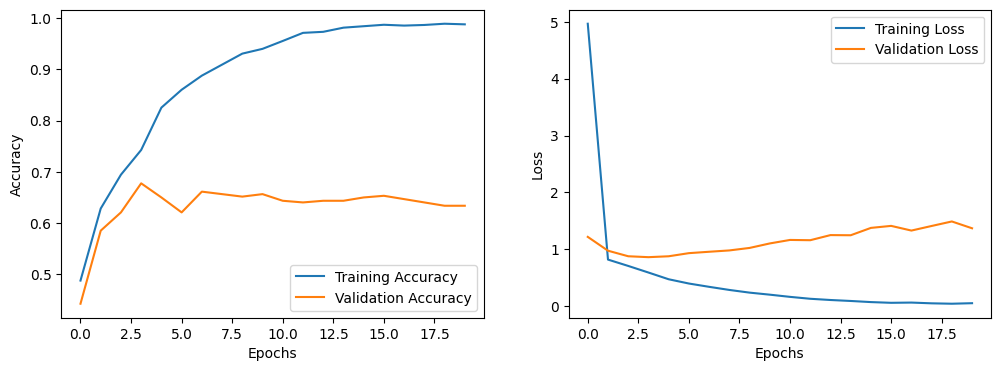

In [61]:
# without neighbouring borders for white images
showDetails(history)

In [24]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')


34/34 [==============================] - 0s 10ms/step - loss: 1.5015 - accuracy: 0.6749
Test accuracy: 0.6748582124710083


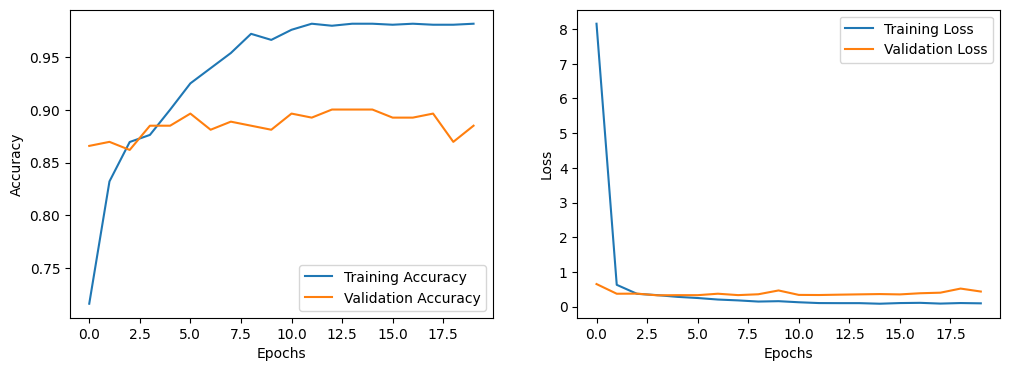

In [73]:
# with neighbouring borders for white images
showDetails(history)

In [74]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')

11/11 [==============================] - 0s 9ms/step - loss: 0.5352 - accuracy: 0.8349
Test accuracy: 0.8348624110221863


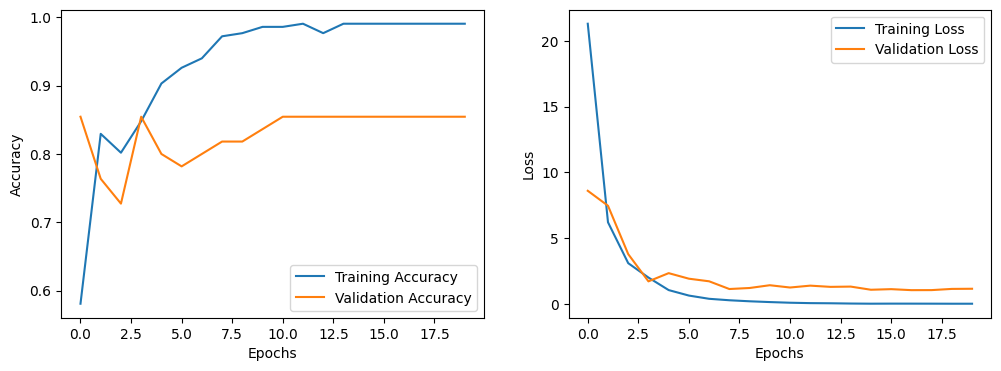

In [61]:
showDetails(history)

In [14]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())


In [21]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()